# Multi-armed bandit problem

The following is a simple implementation of the **multi-armed bandit problem**. The problem is as follows. You are faced with $k$ distributions (or *arms*) which are not known to you. As an example, these could be several variations of *high-frequency trading algorithms* with unknown returns. You can sample from these distributions, and you want to *maximize your reward*, i.e. maximize your average return over time. Currently, the distributions are assumed to be *stationary*.

In this implementation, I additionally include a *hold* parameter, which forces the algorithm to hold the current action for a certain number of steps. This could be desired for example in the context of the trading algorithms, where you want to test a certain algorithm for a certain number of steps before switching to another one.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bandits.arms import NormalArm
from bandits.bandits import EpsilonGreedyBandit, GreedyBandit, UpperConfidenceBoundBandit
from bandits.plots import set_plot_style

In [2]:
# Set plotting style
set_plot_style()

In [3]:
# Set random seed for reproducibility
SEED = 42

There are several variations of bandit algorithms, see [Sutton, Barto (2015)](https://inst.eecs.berkeley.edu//~cs188/sp20/assets/files/SuttonBartoIPRLBook2ndEd.pdf). The following are implemented in this notebook:
- **Greedy bandit algorithm** - The simplest bandit algorithm which always chooses the arm with the highest estimated reward.
- **Epsilon-greedy bandit algorithm** - A simple bandit algorithm which chooses the arm with the highest estimated reward with probability 1-epsilon, and chooses a random arm with probability epsilon.
- **Upper confidence bound (UCB) bandit algorithm** - A bandit algorithm which chooses the arm with the highest estimated reward plus a bonus term which depends on the number of times the arm has been sampled. This bonus term is chosen to be larger for arms which have been sampled few times, and small for arms which have been sampled many times.

In [4]:
# Initialize arms (normal distributions)
means = [0.05, 0.1, 0.09]
sigmas = [0.05, 0.2, 0.1]
arms = [NormalArm(mu, sigma, seed=SEED) for mu, sigma in zip(means, sigmas)]
k = len(arms)


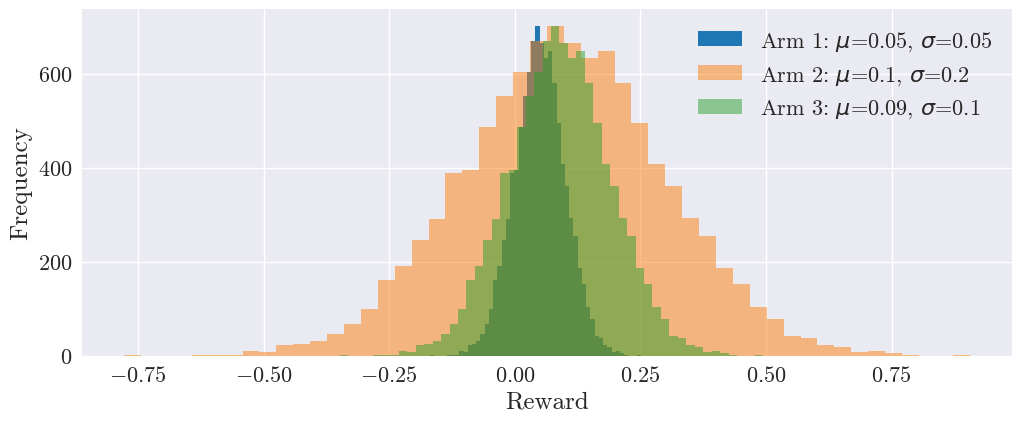

In [5]:
# Sample from the arms
n_samples = 10000
samples = [[arm.sample() for _ in range(n_samples)] for arm in arms]

# Plot the empirical distribution of the arms
fig, ax = plt.subplots(1, 1, figsize=(12, 4.5))
alpha = 1
for i, arm_samples in enumerate(samples):
    ax.hist(arm_samples, bins=50, alpha=alpha, label=f"Arm {i+1}: $\mu$={means[i]}, $\sigma$={sigmas[i]}")
    alpha = 0.5

ax.set_xlabel("Reward")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

In [6]:
# Initialize bandits
bandits = [
    GreedyBandit(k=k, label="Greedy", seed=SEED, hold=30),
    EpsilonGreedyBandit(k=k, label="Eps greedy", epsilon=0.2, seed=SEED, hold=30),
    UpperConfidenceBoundBandit(k=k, label="UCB", c=0.5, seed=SEED, hold=30),
]

In [7]:
# Set number of iterations
n = 3000        # Number of iterations
shift = 100     # Shift for better visualization

In [8]:
# Run the simulation
for _ in range(n + shift):
    for bandit in bandits:
        arm = bandit.select_arm()
        reward = arms[arm].sample()
        bandit.update(arm, reward)

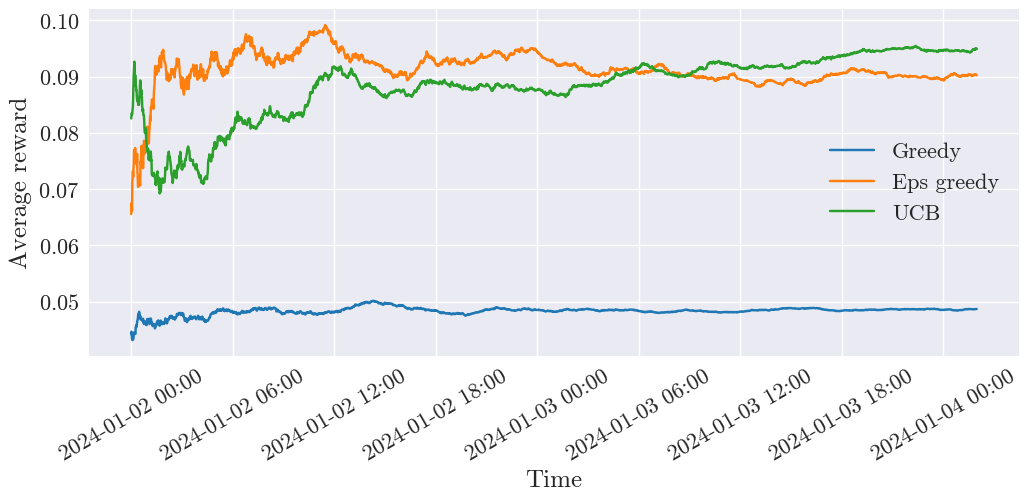

In [9]:
# Generate 1min timestamps
timestamps = pd.date_range(start="2024-01-02", periods=n, freq="1min")

# Plot the average reward over time
fig = plt.figure(figsize=(12, 4.5))
for bandit in bandits:
    rewards = np.array(bandit.rewards)   
    avg_rewards = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
    plt.plot(timestamps, avg_rewards[shift:], label=bandit.label)
plt.xlabel("Time")
plt.ylabel("Average reward")
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d %H:%M"))
plt.legend()
plt.show()